# LightGBM

In [1]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from load import create_features
import lightgbm as lgb
import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [46]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [47]:
lgb.__version__

'3.3.2'

In [68]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def lightgbm_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = lightgbm_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print(f'({i})>expected = {testy}, predicted = {yhat}')
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))    
    return mae, mape, rmse, test[:, -1], predictions

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    #forecast.reset_index(drop = True, inplace = True)
    #test.reset_index(drop = True, inplace = True)
    #errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    # else:
    #     errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures


In [49]:
df_load = load_data()
df_load.head()

,load_mwmed
date,
2000-01-01,4800.650000
2000-01-02,4899.800000
2000-01-03,6261.554167
2000-01-04,6733.741667
2000-01-05,6961.170833


In [50]:
df_weather = pd.read_csv("../data/weather_daily_data.csv", parse_dates=["DATA"])
df_weather.tail()

,DATA,PRECIPITACAO_PR,PRESSAO_ATM_PR,TEMP_AR_BULBO_SECO_PR,TEMP_ORVALHO_PR,UMIDADE_RELATIVA_AR_PR,VELOCIDADE_VENTO_PR,PRECIPITACAO_RS,PRESSAO_ATM_RS,TEMP_AR_BULBO_SECO_RS,TEMP_ORVALHO_RS,UMIDADE_RELATIVA_AR_RS,VELOCIDADE_VENTO_RS,PRECIPITACAO_SC,PRESSAO_ATM_SC,TEMP_AR_BULBO_SECO_SC,TEMP_ORVALHO_SC,UMIDADE_RELATIVA_AR_SC,VELOCIDADE_VENTO_SC
5930,2022-06-26,0.0,942.865015,16.313932,13.692466,83.462329,1.794737,2.4,979.883820,9.384211,7.342044,87.332471,2.456218,0.0,954.529204,12.527729,10.990354,87.463023,2.162832
5931,2022-06-27,0.2,942.038206,15.660465,12.021455,79.221818,2.088040,4.8,975.075118,13.244390,11.627785,89.895006,1.871934,1.2,952.394611,13.890419,12.251014,86.935811,1.915663
5932,2022-06-28,0.2,940.289189,16.617230,12.362593,77.600000,1.814865,258.6,970.942908,14.812515,13.151621,89.861842,2.395478,0.6,948.462952,15.181928,12.397611,81.836177,2.724695
5933,2022-06-29,0.2,939.770508,16.030169,10.994424,73.858736,2.197627,146.4,972.270429,10.450569,7.629843,83.900662,2.602767,52.4,946.143582,12.540896,9.474919,80.452769,3.338806
5934,2022-06-30,0.8,941.674324,13.786149,8.104286,72.796429,1.069932,5.8,975.509954,10.004167,6.557231,81.126708,1.481258,1.2,949.513174,10.449401,5.942157,76.816993,1.615663


In [51]:
df_weather = df_weather[df_weather.DATA.isin(df_load.index)]
df_load = df_load[df_weather.DATA.min():df_weather.DATA.max()] # gets the same period for both dataframes

In [52]:
print(df_weather.shape)
print(df_load.shape)

(5905, 19)
(5906, 1)


In [53]:
df_load_2 = df_load.reset_index()
df_merged = pd.merge(df_weather, df_load_2, left_on = "DATA", right_on = "date", how = "outer")
df_merged.drop("date", axis = 1, inplace = True)
df_merged.isna().sum()

DATA                       1
PRECIPITACAO_PR            1
PRESSAO_ATM_PR             1
TEMP_AR_BULBO_SECO_PR      1
TEMP_ORVALHO_PR            1
UMIDADE_RELATIVA_AR_PR     1
VELOCIDADE_VENTO_PR        1
PRECIPITACAO_RS            1
PRESSAO_ATM_RS             1
TEMP_AR_BULBO_SECO_RS      1
TEMP_ORVALHO_RS            1
UMIDADE_RELATIVA_AR_RS     1
VELOCIDADE_VENTO_RS        1
PRECIPITACAO_SC            1
PRESSAO_ATM_SC             1
TEMP_AR_BULBO_SECO_SC      1
TEMP_ORVALHO_SC            1
UMIDADE_RELATIVA_AR_SC     1
VELOCIDADE_VENTO_SC        1
load_mwmed                13
dtype: int64

In [54]:
df_merged.dropna(how = "all", inplace = True)
df_merged.sort_values(by = "DATA", inplace = True)
df_merged.load_mwmed = df_merged.load_mwmed.interpolate(method="linear")

In [55]:
df_load_3 = df_merged.load_mwmed
values = df_load_3.values.tolist()
# Define the number of lag observations as input (X)
lag = 15 #ou 60
data1 = series_to_supervised(values, n_in = lag, dropnan=False)
data1.head(5)

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),...,var1(t-1),ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,Series,var1(t)
15,7388.445000,6226.141250,8212.231667,8597.089583,8639.442083,8530.962083,8611.037083,7707.624167,6268.828333,8068.169583,...,6404.927083,2006,2,4,16,106,7,15,16,5596.388333
16,6226.141250,8212.231667,8597.089583,8639.442083,8530.962083,8611.037083,7707.624167,6268.828333,8068.169583,8367.525833,...,5596.388333,2006,2,4,17,107,1,16,17,7749.104167
17,8212.231667,8597.089583,8639.442083,8530.962083,8611.037083,7707.624167,6268.828333,8068.169583,8367.525833,8541.254167,...,7749.104167,2006,2,4,18,108,2,16,18,8171.389583
18,8597.089583,8639.442083,8530.962083,8611.037083,7707.624167,6268.828333,8068.169583,8367.525833,8541.254167,8388.782917,...,8171.389583,2006,2,4,19,109,3,16,19,9031.222917
19,8639.442083,8530.962083,8611.037083,7707.624167,6268.828333,8068.169583,8367.525833,8541.254167,8388.782917,6175.557500,...,9031.222917,2006,2,4,20,110,4,16,20,8270.180417


In [56]:
data2 = pd.DataFrame()
for col in df_weather.columns:
    if col == "DATA":
        continue
    else:
        values = df_weather[col].values.tolist()
        df_ = series_to_supervised(values, n_in = lag)
        df_.drop("var1(t)", axis = 1, inplace = True) # the response variable is the load dataframe
        df_.columns = [f"{x}_{col}" for x in df_.columns]
        data2 = pd.concat([data2, df_], axis = 1)
data2.tail()

,var1(t-15)_PRECIPITACAO_PR,var1(t-14)_PRECIPITACAO_PR,var1(t-13)_PRECIPITACAO_PR,var1(t-12)_PRECIPITACAO_PR,var1(t-11)_PRECIPITACAO_PR,var1(t-10)_PRECIPITACAO_PR,var1(t-9)_PRECIPITACAO_PR,var1(t-8)_PRECIPITACAO_PR,var1(t-7)_PRECIPITACAO_PR,var1(t-6)_PRECIPITACAO_PR,...,var1(t-10)_VELOCIDADE_VENTO_SC,var1(t-9)_VELOCIDADE_VENTO_SC,var1(t-8)_VELOCIDADE_VENTO_SC,var1(t-7)_VELOCIDADE_VENTO_SC,var1(t-6)_VELOCIDADE_VENTO_SC,var1(t-5)_VELOCIDADE_VENTO_SC,var1(t-4)_VELOCIDADE_VENTO_SC,var1(t-3)_VELOCIDADE_VENTO_SC,var1(t-2)_VELOCIDADE_VENTO_SC,var1(t-1)_VELOCIDADE_VENTO_SC
5900,5.2,2.2,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,...,4.184062,4.678684,2.647895,1.358047,1.514144,1.512718,1.861596,2.597170,2.802064,1.975399
5901,2.2,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,...,4.678684,2.647895,1.358047,1.514144,1.512718,1.861596,2.597170,2.802064,1.975399,2.324194
5902,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,...,2.647895,1.358047,1.514144,1.512718,1.861596,2.597170,2.802064,1.975399,2.324194,2.068101
5903,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,0.0,...,1.358047,1.514144,1.512718,1.861596,2.597170,2.802064,1.975399,2.324194,2.068101,2.785901
5904,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,0.0,0.4,...,1.514144,1.512718,1.861596,2.597170,2.802064,1.975399,2.324194,2.068101,2.785901,2.101567


In [57]:
df_weather_load = pd.concat([data2, data1], axis = 1)
df_weather_load.tail()

,var1(t-15)_PRECIPITACAO_PR,var1(t-14)_PRECIPITACAO_PR,var1(t-13)_PRECIPITACAO_PR,var1(t-12)_PRECIPITACAO_PR,var1(t-11)_PRECIPITACAO_PR,var1(t-10)_PRECIPITACAO_PR,var1(t-9)_PRECIPITACAO_PR,var1(t-8)_PRECIPITACAO_PR,var1(t-7)_PRECIPITACAO_PR,var1(t-6)_PRECIPITACAO_PR,...,var1(t-1),ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,Series,var1(t)
5900,5.2,2.2,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,...,12482.523708,2022,2,5,27,147,5,21,5901,12520.803833
5901,2.2,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,...,12520.803833,2022,2,5,28,148,6,21,5902,10525.490875
5902,73.2,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,...,10525.490875,2022,2,5,29,149,7,21,5903,9074.211250
5903,15.0,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,0.0,...,9074.211250,2022,2,5,30,150,1,22,5904,11648.709583
5904,1.6,0.2,0.2,1.4,0.4,0.2,0.0,0.0,0.0,0.4,...,11648.709583,2022,2,5,31,151,2,22,5905,12162.756792


In [58]:
mae, mape, rmse, y, yhat = walk_forward_validation(df_weather_load.values, 31)

>expected = 8794.2, predicted = 8483.4
>expected = 11643.8, predicted = 11417.0
>expected = 11941.7, predicted = 11559.6
>expected = 11643.9, predicted = 11958.0
>expected = 11442.4, predicted = 11457.8
>expected = 11156.5, predicted = 11328.1
>expected = 9333.9, predicted = 9806.2
>expected = 7742.4, predicted = 8358.6
>expected = 10808.5, predicted = 10737.9
>expected = 11654.6, predicted = 11545.0
>expected = 11608.5, predicted = 11587.9
>expected = 11361.0, predicted = 11600.1
>expected = 11305.7, predicted = 11154.2
>expected = 10060.5, predicted = 10046.7
>expected = 8994.9, predicted = 8753.1
>expected = 11424.1, predicted = 11406.2
>expected = 11964.9, predicted = 12050.7
>expected = 12269.1, predicted = 11851.8
>expected = 12021.4, predicted = 12294.6
>expected = 11802.5, predicted = 11917.2
>expected = 10257.0, predicted = 10193.9
>expected = 8938.6, predicted = 8538.5
>expected = 11713.1, predicted = 11669.3
>expected = 12054.2, predicted = 12125.7
>expected = 12186.7, predi

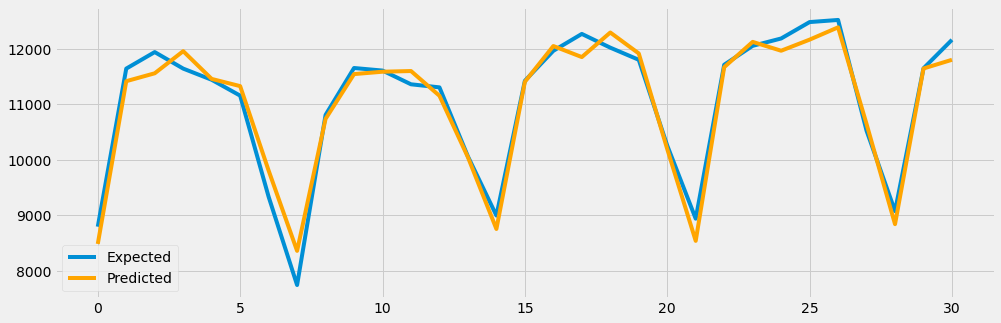

In [60]:
# plot expected vs predicted
plt.plot(y, label = 'Expected')
plt.plot(yhat, label = 'Predicted', color = 'orange')
plt.legend()
plt.show()

In [61]:
measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,1.987543e+06,201.017066,64114.285036,253.207988,0.019293,1.927526


In [121]:
lag = 15 #ou 60
values = df_load_3.values.tolist()
data1 = series_to_supervised(values, n_in = lag)

data2 = pd.DataFrame()
for col in df_weather.columns:
    if col == "DATA":
        continue
    else:
        values = df_weather[col].values.tolist()
        df_ = series_to_supervised(values, n_in = lag)
        df_.drop("var1(t)", axis = 1, inplace = True) # the response variable is the load dataframe
        df_.columns = [f"{x}_{col}" for x in df_.columns]
        data2 = pd.concat([data2, df_], axis = 1)

df_weather_load = pd.concat([data2, data1], axis = 1)
mae, mape, rmse, y, yhat = walk_forward_validation(df_weather_load.values, 31)

>expected = 8794.2, predicted = 9049.8
>expected = 11643.8, predicted = 11477.9
>expected = 11941.7, predicted = 11528.0
>expected = 11643.9, predicted = 11606.1
>expected = 11442.4, predicted = 11441.9
>expected = 11156.5, predicted = 11404.7
>expected = 9333.9, predicted = 9764.8
>expected = 7742.4, predicted = 8437.2
>expected = 10808.5, predicted = 11190.3
>expected = 11654.6, predicted = 11527.0
>expected = 11608.5, predicted = 11658.2
>expected = 11361.0, predicted = 11409.6
>expected = 11305.7, predicted = 11228.5
>expected = 10060.5, predicted = 9787.5
>expected = 8994.9, predicted = 9118.7
>expected = 11424.1, predicted = 11411.8
>expected = 11964.9, predicted = 11869.7
>expected = 12269.1, predicted = 12015.9
>expected = 12021.4, predicted = 12102.5
>expected = 11802.5, predicted = 11721.3
>expected = 10257.0, predicted = 10621.3
>expected = 8938.6, predicted = 9011.1
>expected = 11713.1, predicted = 11688.1
>expected = 12054.2, predicted = 12154.8
>expected = 12186.7, predic

In [123]:
measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,1.911487e+06,190.359885,61660.876618,248.316082,0.018285,1.813949


In [125]:
lag = 15 #ou 60
values = df_load_3.values.tolist()
data1 = series_to_supervised(values, n_in = lag)

data2 = pd.DataFrame()
for col in df_weather.columns:
    if col == "DATA":
        continue
    else:
        values = df_weather[col].values.tolist()
        df_ = series_to_supervised(values, n_in = lag)
        df_.drop("var1(t)", axis = 1, inplace = True) # the response variable is the load dataframe
        df_.columns = [f"{x}_{col}" for x in df_.columns]
        data2 = pd.concat([data2, df_], axis = 1)

df_weather_load = pd.concat([data2, data1], axis = 1)
mae, mape, rmse, y, yhat = walk_forward_validation(df_weather_load.values, 31)

measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

>expected = 8794.2, predicted = 9026.7
>expected = 11643.8, predicted = 11599.0
>expected = 11941.7, predicted = 11935.0
>expected = 11643.9, predicted = 11810.4
>expected = 11442.4, predicted = 11415.4
>expected = 11156.5, predicted = 11009.8
>expected = 9333.9, predicted = 9718.2
>expected = 7742.4, predicted = 8365.0
>expected = 10808.5, predicted = 10736.4
>expected = 11654.6, predicted = 11324.7
>expected = 11608.5, predicted = 11586.1
>expected = 11361.0, predicted = 11574.2
>expected = 11305.7, predicted = 10832.0
>expected = 10060.5, predicted = 10075.2
>expected = 8994.9, predicted = 9096.8
>expected = 11424.1, predicted = 11470.9
>expected = 11964.9, predicted = 11927.7
>expected = 12269.1, predicted = 11957.7
>expected = 12021.4, predicted = 12019.5
>expected = 11802.5, predicted = 11686.8
>expected = 10257.0, predicted = 10075.1
>expected = 8938.6, predicted = 8820.0
>expected = 11713.1, predicted = 11726.1
>expected = 12054.2, predicted = 12083.3
>expected = 12186.7, predi

,erro,mae,mse,rmse,mape,smape
0,1.558009e+06,161.302997,50258.353904,224.18375,0.015506,1.546453


In [70]:
lag = 15 #ou 60
values = df_load_3.values.tolist()
data1 = series_to_supervised(values, n_in = lag)
# data1["DATA"] = df_merged["DATA"]
# data1 = create_features(data1, "DATA")
# data1.drop("DATA", axis = 1, inplace = True)
# data1 = data1[['var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
#        'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
#        'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
#        'ano', 'trimestre', 'mes', 'dia', 'dia_ano', 'dia_semana',
#        'semana_ano', 'Series', 'var1(t)']]
# data1.dropna(inplace = True)

data2 = pd.DataFrame()
for col in df_weather.columns:
    if col == "DATA":
        continue
    else:
        values = df_weather[col].values.tolist()
        df_ = series_to_supervised(values, n_in = lag)
        df_.drop("var1(t)", axis = 1, inplace = True) # the response variable is the load dataframe
        df_.columns = [f"{x}_{col}" for x in df_.columns]
        data2 = pd.concat([data2, df_], axis = 1)

df_weather_load = pd.concat([data2, data1], axis = 1)
mae, mape, rmse, y, yhat = walk_forward_validation(df_weather_load.values, 31)

measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

(0)>expected = 8794.163125, predicted = 9026.650223766306
(1)>expected = 11643.82154167, predicted = 11598.964931318033
(2)>expected = 11941.66258333, predicted = 11935.005608799056
(3)>expected = 11643.86191667, predicted = 11810.379256035645
(4)>expected = 11442.40841667, predicted = 11415.430837157963
(5)>expected = 11156.521, predicted = 11009.797275742827
(6)>expected = 9333.92008333, predicted = 9718.183758796682
(7)>expected = 7742.3945, predicted = 8364.97914390584
(8)>expected = 10808.54866667, predicted = 10736.397234994649
(9)>expected = 11654.62308112, predicted = 11324.690310835089
(10)>expected = 11608.52466322, predicted = 11586.10839299864
(11)>expected = 11361.00188129, predicted = 11574.208346422363
(12)>expected = 11305.70706206, predicted = 10832.035973810058
(13)>expected = 10060.54978729, predicted = 10075.2314197139
(14)>expected = 8994.85674774, predicted = 9096.807478431643
(15)>expected = 11424.08754167, predicted = 11470.913370986033
(16)>expected = 11964.909

,erro,mae,mse,rmse,mape,smape
0,1.558009e+06,161.302997,50258.353904,224.18375,0.015506,1.546453
